[FIFA 18 Complete Player Dataset analysis](https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset)

Author: Ilya Borovik (@ilya16)

# Goals

* Finding associations rules between player positions on the field;
* Finding correlations between football skills and positions (which skills are most common for each position);
* Multi-label predicting of player positions based on skills;
* Creating and testing algorithms for finding the most optimal football squad for a set of players (real or any imaginary team);

# Environment Setup

Defining useful imports

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

import keras
from keras.models import Sequential
from keras.layers import Dense

# Dataset

In [3]:
df = pd.read_csv('./fifa-18/CompleteDataset.csv', index_col=0, low_memory=False)

Looking at available features:

In [4]:
df.columns

Index(['Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential',
       'Club', 'Club Logo', 'Value', 'Wage', 'Special', 'Acceleration',
       'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure',
       'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy',
       'GK diving', 'GK handling', 'GK kicking', 'GK positioning',
       'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping',
       'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
       'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
       'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
       'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID', 'LAM', 'LB', 'LCB',
       'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'Preferred Positions',
       'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

Looking at first rows of the dataset:

In [5]:
df.head(10)

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,R. Lewandowski,28,https://cdn.sofifa.org/48/18/players/188545.png,Poland,https://cdn.sofifa.org/flags/37.png,91,91,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€92M,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0
6,De Gea,26,https://cdn.sofifa.org/48/18/players/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,90,92,Manchester United,https://cdn.sofifa.org/24/18/teams/11.png,€64.5M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,E. Hazard,26,https://cdn.sofifa.org/48/18/players/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,90,91,Chelsea,https://cdn.sofifa.org/24/18/teams/5.png,€90.5M,...,59.0,47.0,81.0,61.0,87.0,87.0,82.0,88.0,64.0,82.0
8,T. Kroos,27,https://cdn.sofifa.org/48/18/players/182521.png,Germany,https://cdn.sofifa.org/flags/21.png,90,90,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€79M,...,76.0,72.0,87.0,82.0,81.0,81.0,77.0,80.0,78.0,77.0
9,G. Higuaín,29,https://cdn.sofifa.org/48/18/players/167664.png,Argentina,https://cdn.sofifa.org/flags/52.png,90,90,Juventus,https://cdn.sofifa.org/24/18/teams/45.png,€77M,...,51.0,46.0,71.0,52.0,84.0,79.0,87.0,82.0,55.0,87.0


All features can be divided into these groups:
* Player Personal Data
* Player Attribute Data
* Player Playing Position Data

# Preprocessing

Preprocessing methods

In [6]:
def remove_goalkeepers(df):
    df.loc[:, 'Preferred Positions'] = df['Preferred Positions'].str.strip()
    df = df[df['Preferred Positions'] != 'GK']
    return df

In [7]:
def evaluate_skills(df, skills_features):
    for s in skills_features:
        df[s] = df[s].apply(lambda x: eval(x) if isinstance(x,str) else x)
    return df

# Experiments

## Player Positions Patterns

The first problem we are going to address is the player positions patterns.

At first we have to select only needed features and filter out goalkeepers since they have only one position – 'GK'.

In [8]:
# positions from defensive to attacking ones
goalkeeper_position = ['GK']
defender_positions = ['CB', 'LCB', 'RCB', 'LB', 'RB', 'LWB', 'RWB',]
midfilder_positions = ['CDM', 'LDM', 'RDM', 'CM', 'LCM', 'RCM', 'LM', 'RM', 'CAM', 'LAM', 'RAM',]
forward_positions = ['LW', 'RW', 'CF', 'LF', 'RF', 'LS', 'RS', 'ST',]
        
player_positions = defender_positions + midfilder_positions + forward_positions

df_positions = df[player_positions + ['Preferred Positions',]]
df_positions.head()

,CB,LCB,RCB,LB,RB,LWB,RWB,CDM,LDM,RDM,...,RAM,LW,RW,CF,LF,RF,LS,RS,ST,Preferred Positions
0,53.0,53.0,53.0,61.0,61.0,66.0,66.0,62.0,62.0,62.0,...,89.0,91.0,91.0,91.0,91.0,91.0,92.0,92.0,92.0,ST LW
1,45.0,45.0,45.0,57.0,57.0,62.0,62.0,59.0,59.0,59.0,...,92.0,91.0,91.0,92.0,92.0,92.0,88.0,88.0,88.0,RW
2,46.0,46.0,46.0,59.0,59.0,64.0,64.0,59.0,59.0,59.0,...,88.0,89.0,89.0,88.0,88.0,88.0,84.0,84.0,84.0,LW
3,58.0,58.0,58.0,64.0,64.0,68.0,68.0,65.0,65.0,65.0,...,87.0,87.0,87.0,88.0,88.0,88.0,88.0,88.0,88.0,ST
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK


Associations between positions are compared by two approaches: 
* by observing 'Preferred Positions' column
* by taking best positions from positions ratings

Filtering out goalkeeper since they have always ony one preferred position.

In [9]:
df_positions = remove_goalkeepers(df_positions)
df_positions.head()

/Users/ilyaborovik/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,CB,LCB,RCB,LB,RB,LWB,RWB,CDM,LDM,RDM,...,RAM,LW,RW,CF,LF,RF,LS,RS,ST,Preferred Positions
0,53.0,53.0,53.0,61.0,61.0,66.0,66.0,62.0,62.0,62.0,...,89.0,91.0,91.0,91.0,91.0,91.0,92.0,92.0,92.0,ST LW
1,45.0,45.0,45.0,57.0,57.0,62.0,62.0,59.0,59.0,59.0,...,92.0,91.0,91.0,92.0,92.0,92.0,88.0,88.0,88.0,RW
2,46.0,46.0,46.0,59.0,59.0,64.0,64.0,59.0,59.0,59.0,...,88.0,89.0,89.0,88.0,88.0,88.0,84.0,84.0,84.0,LW
3,58.0,58.0,58.0,64.0,64.0,68.0,68.0,65.0,65.0,65.0,...,87.0,87.0,87.0,88.0,88.0,88.0,88.0,88.0,88.0,ST
5,57.0,57.0,57.0,58.0,58.0,61.0,61.0,62.0,62.0,62.0,...,84.0,84.0,84.0,87.0,87.0,87.0,88.0,88.0,88.0,ST


Transforming positions into a transaction database to apply Apriori algorithm.

In [10]:
df_positions_binary = df_positions.copy()
df_positions_binary.loc[:, :-1] = 0

for index, row in df_positions_binary.iterrows():
    for pos in row['Preferred Positions'].split():
        df_positions_binary.loc[index:index, pos:pos] = 1 

df_positions_binary.iloc[::2000, :]

,CB,LCB,RCB,LB,RB,LWB,RWB,CDM,LDM,RDM,...,RAM,LW,RW,CF,LF,RF,LS,RS,ST,Preferred Positions
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,ST LW
2225,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,LB
4411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CM
6615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,ST
8828,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,RB CB
11040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,ST
13305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CM
15593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,ST


Removing last column

In [11]:
df_positions_binary = df_positions_binary.iloc[:, :-1]
df_positions_binary.iloc[::2000, :]

,CB,LCB,RCB,LB,RB,LWB,RWB,CDM,LDM,RDM,...,LAM,RAM,LW,RW,CF,LF,RF,LS,RS,ST
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2225,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8828,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Finding frequent itemsets

In [12]:
frequent_itemsets = apriori(df_positions_binary, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.227558,[CB]
1,0.128573,[LB]
2,0.127821,[RB]
3,0.011785,[LWB]
4,0.011848,[RWB]
5,0.166938,[CDM]
6,0.224987,[CM]
7,0.159729,[LM]
8,0.159353,[RM]
9,0.142991,[CAM]


Mining Association Rules

In [13]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(RB),(CB),0.127821,0.227558,0.034604,0.270721,1.189681,0.005517,1.059186
1,(CB),(RB),0.227558,0.127821,0.034604,0.152066,1.189681,0.005517,1.028593
2,(LB),(RB),0.128573,0.127821,0.026204,0.203803,1.594441,0.009769,1.095431
3,(RB),(LB),0.127821,0.128573,0.026204,0.205002,1.594441,0.009769,1.096138
4,(LB),(LM),0.128573,0.159729,0.023633,0.183813,1.150778,0.003097,1.029507
5,(LM),(LB),0.159729,0.128573,0.023633,0.147959,1.150778,0.003097,1.022752
6,(RB),(RM),0.127821,0.159353,0.021878,0.171162,1.074108,0.001509,1.014248
7,(RM),(RB),0.159353,0.127821,0.021878,0.137293,1.074108,0.001509,1.010980
8,(CM),(CDM),0.224987,0.166938,0.106068,0.471441,2.824040,0.068509,1.576098
9,(CDM),(CM),0.166938,0.224987,0.106068,0.635374,2.824040,0.068509,2.125498


In [14]:
rules[rules['confidence'] >= 0.5]

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(CDM),(CM),0.166938,0.224987,0.106068,0.635374,2.824040,0.068509,2.125498
31,"(CAM, CDM)",(CM),0.017365,0.224987,0.014230,0.819495,3.642401,0.010323,4.293569
35,"(CAM, RM)",(LM),0.033977,0.159729,0.017365,0.511070,3.199604,0.011937,1.718592


If we look at the mined rules, we can see that they are quite predictable – midfielder positions (CM, CAM, RM, LM) come together.

# Player Positions Prediction

In [15]:
# GK attributes are not our interest
attacking_attributes = ['Crossing', 'Heading accuracy', 'Short passing', 'Volleys', 'Finishing',]
skill_attributes = ['Free kick accuracy', 'Curve', 'Long passing', 'Dribbling', 'Ball control',]
movement_attributes = ['Acceleration', 'Sprint speed', 'Agility', 'Reactions', 'Balance',]
power_attributes = ['Shot power', 'Jumping', 'Stamina', 'Strength', 'Long shots',]
mentality_attributes = ['Positioning', 'Vision', 'Penalties', 'Composure', 'Aggression', 'Interceptions',]
defending_attributes = ['Marking', 'Standing tackle', 'Sliding tackle',]         

skills_features = attacking_attributes + skill_attributes + movement_attributes \
    + power_attributes + mentality_attributes + defending_attributes

df_skills = df[skills_features + ['Preferred Positions']]
df_skills.head()

,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,Positioning,Vision,Penalties,Composure,Aggression,Interceptions,Marking,Standing tackle,Sliding tackle,Preferred Positions
0,85,88,83,88,94,76,81,77,91,93,...,95,85,85,95,63,29,22,31,23,ST LW
1,77,71,88,85,95,90,89,87,97,95,...,93,90,74,96,48,22,13,28,26,RW
2,75,62,81,83,89,84,81,75,96,95,...,90,80,81,92,56,36,21,24,33,LW
3,77,77,83,88,94,84,86,64,86,91,...,92,84,85,83,78,41,30,45,38,ST
4,15,25,55,11,13,11,14,59,30,48,...,12,70,47,70,29,30,10,10,11,GK


Removing goalkeepers from analysis

In [16]:
df_skills = remove_goalkeepers(df_skills)
df_skills.head()

/Users/ilyaborovik/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,Positioning,Vision,Penalties,Composure,Aggression,Interceptions,Marking,Standing tackle,Sliding tackle,Preferred Positions
0,85,88,83,88,94,76,81,77,91,93,...,95,85,85,95,63,29,22,31,23,ST LW
1,77,71,88,85,95,90,89,87,97,95,...,93,90,74,96,48,22,13,28,26,RW
2,75,62,81,83,89,84,81,75,96,95,...,90,80,81,92,56,36,21,24,33,LW
3,77,77,83,88,94,84,86,64,86,91,...,92,84,85,83,78,41,30,45,38,ST
5,62,85,83,87,91,84,77,65,85,89,...,91,78,81,87,80,39,25,42,19,ST


Evaluating skills that are presented in a form `X±Y`

In [17]:
df_skills = evaluate_skills(df_skills, skills_features)
df_skills.iloc[::2000, :]

,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,Positioning,Vision,Penalties,Composure,Aggression,Interceptions,Marking,Standing tackle,Sliding tackle,Preferred Positions
0,85,88,83,88,94,76,81,77,91,93,...,95,85,85,95,63,29,22,31,23,ST LW
2225,71,72,68,35,28,34,52,61,74,73,...,68,67,49,65,68,73,69,72,71,LB
4411,59,46,76,61,50,55,70,72,76,78,...,64,70,58,63,54,41,40,57,51,CM
6615,48,63,61,71,66,41,48,60,65,68,...,63,61,63,60,44,15,16,12,13,ST
8828,56,47,63,12,30,22,48,59,33,53,...,39,38,37,57,75,62,64,67,66,RB CB
11040,34,70,54,57,65,31,34,35,64,68,...,60,49,55,54,55,19,23,28,22,ST
13305,57,44,66,37,53,59,54,61,61,60,...,58,61,35,53,65,53,57,56,49,CM
15593,33,56,50,40,61,33,41,28,58,52,...,51,44,55,43,33,25,14,24,23,ST


Making preferred position column atomic by splitting making a copy of skills rows.

In [18]:
# copy a structure
df_skills_new = df_skills.copy()
df_skills_new.drop(df_skills_new.index, inplace=True)

for p in player_positions:
    df_temp = df_skills[df_skills['Preferred Positions'].str.contains(p)]
    df_temp['Preferred Positions'] = p
    df_skills_new = df_skills_new.append(df_temp, ignore_index=True)
    
df_skills_new.iloc[::2000, :]

/Users/ilyaborovik/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,Positioning,Vision,Penalties,Composure,Aggression,Interceptions,Marking,Standing tackle,Sliding tackle,Preferred Positions
0,66,91,78,66,60,67,73,72,61,84,...,52,63,68,80,84,88,86,89,91,CB
2000,27,65,45,32,20,62,55,35,22,43,...,24,28,37,42,65,63,66,67,65,CB
4000,70,63,63,46,40,50,66,59,61,66,...,56,52,64,72,74,77,75,70,71,LB
6000,74,66,71,59,59,68,71,64,67,69,...,65,67,64,70,67,66,69,66,68,RB
8000,68,47,56,37,26,34,50,51,43,63,...,46,44,45,42,75,64,68,67,64,RWB
10000,32,51,61,51,31,39,54,60,29,50,...,49,48,33,64,71,66,64,64,63,CDM
12000,62,47,70,45,54,48,52,70,68,69,...,59,68,40,61,75,65,56,60,61,CM
14000,47,36,59,39,32,44,60,58,62,61,...,43,57,50,60,70,50,52,47,49,CM
16000,59,45,66,42,34,34,45,57,54,62,...,49,45,44,60,53,57,62,65,65,LM
18000,60,64,70,63,65,57,44,64,76,76,...,70,68,59,72,44,31,49,44,48,RM


Available positions

In [21]:
player_positions_pref = df_skills_new['Preferred Positions'].apply(lambda x: x).unique()
print(player_positions)
print(player_positions_pref)

['CB', 'LCB', 'RCB', 'LB', 'RB', 'LWB', 'RWB', 'CDM', 'LDM', 'RDM', 'CM', 'LCM', 'RCM', 'LM', 'RM', 'CAM', 'LAM', 'RAM', 'LW', 'RW', 'CF', 'LF', 'RF', 'LS', 'RS', 'ST']
['CB' 'LB' 'RB' 'LWB' 'RWB' 'CDM' 'CM' 'LM' 'RM' 'CAM' 'LW' 'RW' 'CF' 'ST']


As we can see, not all player positions are being preferred by players.

In [22]:
defender_positions_pref = [pos for pos in defender_positions if pos in player_positions_pref]
midfilder_positions_pref = [pos for pos in midfilder_positions if pos in player_positions_pref]
forward_positions_pref = [pos for pos in forward_positions if pos in player_positions_pref]

print(defender_positions_pref)
print(midfilder_positions_pref)
print(forward_positions_pref)

['CB', 'LB', 'RB', 'LWB', 'RWB']
['CDM', 'CM', 'LM', 'RM', 'CAM']
['LW', 'RW', 'CF', 'ST']


## Plotting some graphs

Counting each position.

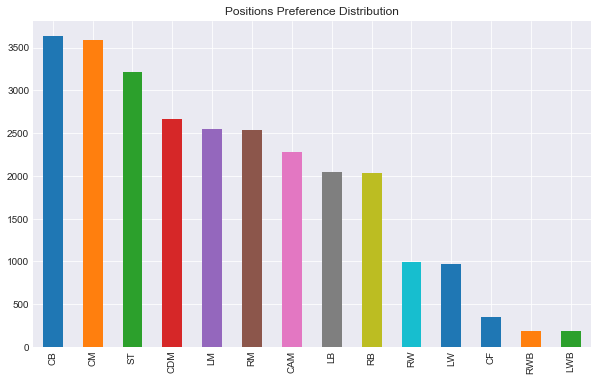

In [23]:
df_skills_new['Preferred Positions'].value_counts().plot.bar(title = 'Positions Preference Distribution', figsize = (10,6))
plt.show()

Checking how many have several positions.

In [25]:
df_skills[df_skills['Preferred Positions'].str.split().apply(len) > 1].shape

(8243, 30)

Since not all positions are preferred, we can plot graphs only for those that are preferred.

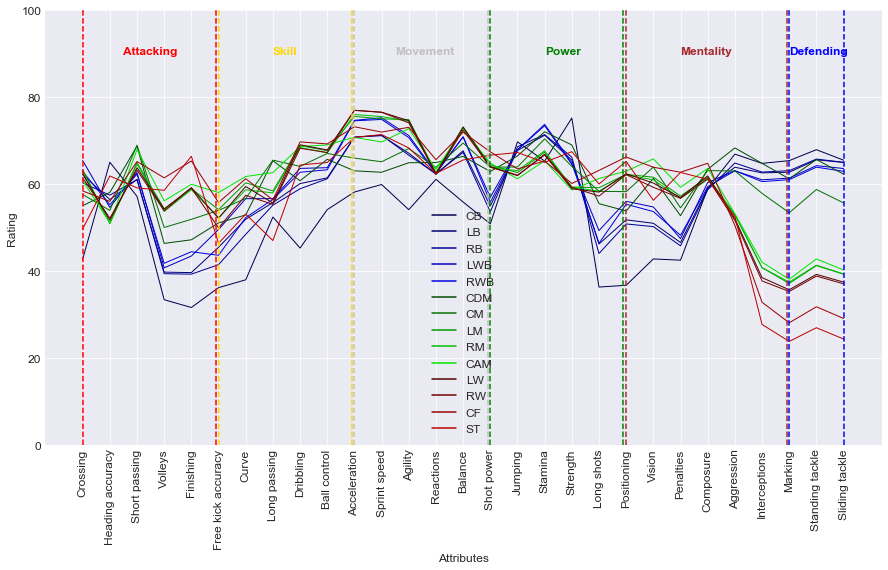

In [28]:
plt.close()
fig, ax = plt.subplots()

c = 0.3
for pos in defender_positions_pref:
    df_skills_one = df_skills_new[df_skills_new['Preferred Positions'] == pos].mean()
    df_skills_one.T.plot.line(color = (0.0, 0.0, c), figsize = (15,8), legend = False, ylim = (0, 100), ax=ax)
    c += 0.15
    
c = 0.3
for pos in midfilder_positions_pref:
    df_skills_one = df_skills_new[df_skills_new['Preferred Positions'] == pos].mean()
    df_skills_one.T.plot.line(color = (0.0, c, 0.0), figsize = (15,8), legend = False, ylim = (0, 100), ax=ax)
    c += 0.15  
    
c = 0.3
for pos in forward_positions_pref:
    df_skills_one = df_skills_new[df_skills_new['Preferred Positions'] == pos].mean()
    df_skills_one.T.plot.line(color = (c, 0.0, 0.0), figsize = (15,8), legend = False, ylim = (0, 100), ax=ax)
    c += 0.15
    
ax.legend(defender_positions_pref + midfilder_positions_pref + forward_positions_pref)    
    
ax.set_xlabel('Attributes')
ax.set_ylabel('Rating')

ax.set_xticks(np.arange(len(skills_features)))
ax.set_xticklabels(labels = skills_features, rotation=90)

for ln in ax.lines:
    ln.set_linewidth(1)

ax.axvline(0, color='red', linestyle='--')   
ax.axvline(4.9, color='red', linestyle='--')

ax.axvline(5, color='gold', linestyle='--')
ax.axvline(9.9, color='gold', linestyle='--')

ax.axvline(10, color='silver', linestyle='--')
ax.axvline(14.9, color='silver', linestyle='--')

ax.axvline(15, color='green', linestyle='--')
ax.axvline(19.9, color='green', linestyle='--')

ax.axvline(20, color='brown', linestyle='--')
ax.axvline(25.9, color='brown', linestyle='--')

ax.axvline(26, color='blue', linestyle='--')
ax.axvline(28, color='blue', linestyle='--')

ax.text(1.5, 90, 'Attacking', color = 'red', weight = 'bold')
ax.text(7, 90, 'Skill', color = 'gold', weight = 'bold')
ax.text(11.5, 90, 'Movement', color = 'silver', weight = 'bold')
ax.text(17, 90, 'Power', color = 'green', weight = 'bold')
ax.text(22, 90, 'Mentality', color = 'brown', weight = 'bold')
ax.text(26, 90, 'Defending', color = 'blue', weight = 'bold')

plt.show()

Looks not clear. However, some patterns can be observed.

For example, it is easy to notice that `Defending` attributes are much higher for defenders, as well as `Interceptions` for defenders and midfielders that play on adjacent positions.

Midfielders are more skilled (`Skills` attributes) ones and Center Backs (CB) are worse in almost everything except defending.

Let's make a plot by dividing into there major groups.

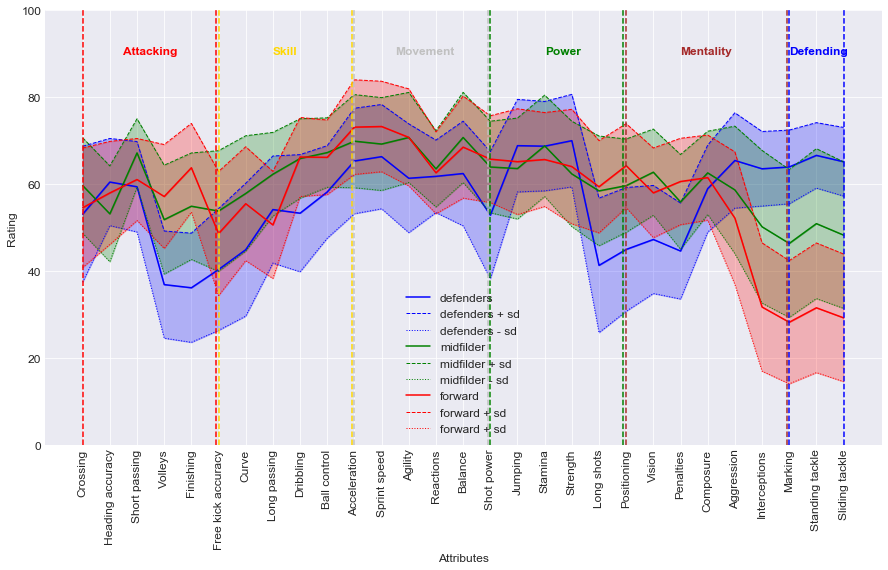

In [29]:
plt.close()
fig, ax = plt.subplots()

c = 0.7
df_skills_one = df_skills_new[df_skills_new['Preferred Positions'].isin(defender_positions)].mean()
df_skills_one.T.plot.line(color = 'blue', figsize = (15,8), label = 'defenders', ylim = (0, 100), ax=ax)

df_skills_one_var = df_skills_new[df_skills_new['Preferred Positions'].isin(defender_positions)].var().apply(lambda x: x ** .5)
(df_skills_one + df_skills_one_var).T.plot.line(color = 'blue', figsize = (15,8), label = 'defenders + sd', ylim = (0, 100), ax=ax, linestyle='--', linewidth=1.)
(df_skills_one - df_skills_one_var).T.plot.line(color = 'blue', figsize = (15,8), label = 'defenders - sd', ylim = (0, 100), ax=ax, linestyle=':', linewidth=1.)
plt.fill_between(df_skills_one.index, df_skills_one, df_skills_one + df_skills_one_var, color='blue', alpha=0.25)
plt.fill_between(df_skills_one.index, df_skills_one, df_skills_one - df_skills_one_var, color='blue', alpha=0.25)

df_skills_one = df_skills_new[df_skills_new['Preferred Positions'].isin(midfilder_positions)].mean()
df_skills_one.T.plot.line(color = 'green', figsize = (15,8), label = 'midfilder', ylim = (0, 100), ax=ax) 

df_skills_one_var = df_skills_new[df_skills_new['Preferred Positions'].isin(midfilder_positions)].var().apply(lambda x: x ** .5)
(df_skills_one + df_skills_one_var).T.plot.line(color = 'green', figsize = (15,8), label = 'midfilder + sd', ylim = (0, 100), ax=ax, linestyle='--', linewidth=1.)
(df_skills_one - df_skills_one_var).T.plot.line(color = 'green', figsize = (15,8), label = 'midfilder - sd', ylim = (0, 100), ax=ax, linestyle=':', linewidth=1.)
plt.fill_between(df_skills_one.index, df_skills_one, df_skills_one + df_skills_one_var, color='green', alpha=0.25)
plt.fill_between(df_skills_one.index, df_skills_one, df_skills_one - df_skills_one_var, color='green', alpha=0.25)

df_skills_one = df_skills_new[df_skills_new['Preferred Positions'].isin(forward_positions)].mean()
df_skills_one.T.plot.line(color = 'red', figsize = (15,8), label = 'forward', ylim = (0, 100), ax=ax)

df_skills_one_var = df_skills_new[df_skills_new['Preferred Positions'].isin(forward_positions)].var().apply(lambda x: x ** .5)
(df_skills_one + df_skills_one_var).T.plot.line(color = 'red', figsize = (15,8), label = 'forward + sd', ylim = (0, 100), ax=ax, linestyle='--', linewidth=1.)
(df_skills_one - df_skills_one_var).T.plot.line(color = 'red', figsize = (15,8), label = 'forward + sd', ylim = (0, 100), ax=ax, linestyle=':', linewidth=1.)
plt.fill_between(df_skills_one.index, df_skills_one, df_skills_one + df_skills_one_var, color='red', alpha=0.25)
plt.fill_between(df_skills_one.index, df_skills_one, df_skills_one - df_skills_one_var, color='red', alpha=0.25)
    
ax.legend()  
    
ax.set_xlabel('Attributes')
ax.set_ylabel('Rating')

ax.set_xticks(np.arange(len(skills_features)))
ax.set_xticklabels(labels = skills_features, rotation=90)

ax.axvline(0, color='red', linestyle='--')   
ax.axvline(4.9, color='red', linestyle='--')

ax.axvline(5, color='gold', linestyle='--')
ax.axvline(9.9, color='gold', linestyle='--')

ax.axvline(10, color='silver', linestyle='--')
ax.axvline(14.9, color='silver', linestyle='--')

ax.axvline(15, color='green', linestyle='--')
ax.axvline(19.9, color='green', linestyle='--')

ax.axvline(20, color='brown', linestyle='--')
ax.axvline(25.9, color='brown', linestyle='--')

ax.axvline(26, color='blue', linestyle='--')
ax.axvline(28, color='blue', linestyle='--')

ax.text(1.5, 90, 'Attacking', color = 'red', weight = 'bold')
ax.text(7, 90, 'Skill', color = 'gold', weight = 'bold')
ax.text(11.5, 90, 'Movement', color = 'silver', weight = 'bold')
ax.text(17, 90, 'Power', color = 'green', weight = 'bold')
ax.text(22, 90, 'Mentality', color = 'brown', weight = 'bold')
ax.text(26, 90, 'Defending', color = 'blue', weight = 'bold')

plt.show()

## Multilabel classification based on `Preferred Positions` attribute

In [30]:
df_positions_binary.iloc[::2000, :]

,CB,LCB,RCB,LB,RB,LWB,RWB,CDM,LDM,RDM,...,LAM,RAM,LW,RW,CF,LF,RF,LS,RS,ST
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2225,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8828,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [178]:
df_skills_multilabel = df_skills.copy()

for pos in player_positions_pref:
    df_skills_multilabel[pos] = df_positions_binary[pos]
df_skills_multilabel = df_skills_multilabel.drop('Preferred Positions', axis=1)

df_skills_multilabel.iloc[::2000, :]

,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,RWB,CDM,CM,LM,RM,CAM,LW,RW,CF,ST
0,85,88,83,88,94,76,81,77,91,93,...,0,0,0,0,0,0,1,0,0,1
2225,71,72,68,35,28,34,52,61,74,73,...,0,0,0,0,0,0,0,0,0,0
4411,59,46,76,61,50,55,70,72,76,78,...,0,0,1,0,0,0,0,0,0,0
6615,48,63,61,71,66,41,48,60,65,68,...,0,0,0,0,0,0,0,0,0,1
8828,56,47,63,12,30,22,48,59,33,53,...,0,0,0,0,0,0,0,0,0,0
11040,34,70,54,57,65,31,34,35,64,68,...,0,0,0,0,0,0,0,0,0,1
13305,57,44,66,37,53,59,54,61,61,60,...,0,0,1,0,0,0,0,0,0,0
15593,33,56,50,40,61,33,41,28,58,52,...,0,0,0,0,0,0,0,0,0,1


Checking how many labels on average each player has 

In [226]:
df_skills_multilabel.iloc[:,29:].sum().sum() / df_skills_multilabel.iloc[:,29:].shape[0]

1.6853059177532599

Splitting dataset

In [179]:
X_train_multi_pref, X_test_multi_pref, y_train_multi_pref, y_test_multi_pref = train_test_split(df_skills_multilabel.iloc[:,:29], df_skills_multilabel.iloc[:,29:], random_state=0)

print('X train shape: {}'.format(X_train_multi_pref.shape))
print('X test shape: {}'.format(X_test_multi_pref.shape))
print('y train shape: {}'.format(y_train_multi_pref.shape))
print('y test shape: {}'.format(y_test_multi_pref.shape))

X train shape: (11964, 29)
X test shape: (3988, 29)
y train shape: (11964, 14)
y test shape: (3988, 14)


Fitting each model

In [187]:
dec_tree_clf = DecisionTreeClassifier()
dec_tree_clf.fit(np.array(X_train_multi_pref), np.array(y_train_multi_pref))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [202]:
rnd_forest_clf = RandomForestClassifier(n_estimators=100)
rnd_forest_clf.fit(np.array(X_train_multi_pref), np.array(y_train_multi_pref))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [234]:
fcnn = Sequential()

fcnn.add(Dense(units=50, activation='relu', input_shape=(29,)))
fcnn.add(Dense(units=100, activation='relu'))
fcnn.add(Dense(units=14, activation='sigmoid'))

fcnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

# Fitting the model
fcnn.fit(np.array(X_train_multi_pref), 
          np.array(y_train_multi_pref),
          batch_size=16,
          epochs=15,
          verbose=2, 
          validation_split=0.2)

Train on 9571 samples, validate on 2393 samples
Epoch 1/15
2s - loss: 2.0624 - acc: 0.8117 - categorical_accuracy: 0.1795 - val_loss: 0.4846 - val_acc: 0.8982 - val_categorical_accuracy: 0.4576
Epoch 2/15
1s - loss: 0.2818 - acc: 0.9062 - categorical_accuracy: 0.4894 - val_loss: 0.2155 - val_acc: 0.9095 - val_categorical_accuracy: 0.5441
Epoch 3/15
1s - loss: 0.2100 - acc: 0.9130 - categorical_accuracy: 0.5120 - val_loss: 0.2066 - val_acc: 0.9139 - val_categorical_accuracy: 0.5061
Epoch 4/15
1s - loss: 0.2028 - acc: 0.9144 - categorical_accuracy: 0.5169 - val_loss: 0.1973 - val_acc: 0.9171 - val_categorical_accuracy: 0.5370
Epoch 5/15
2s - loss: 0.1993 - acc: 0.9159 - categorical_accuracy: 0.5228 - val_loss: 0.1947 - val_acc: 0.9169 - val_categorical_accuracy: 0.5048
Epoch 6/15
2s - loss: 0.1963 - acc: 0.9167 - categorical_accuracy: 0.5290 - val_loss: 0.1980 - val_acc: 0.9147 - val_categorical_accuracy: 0.5303
Epoch 7/15
2s - loss: 0.1946 - acc: 0.9177 - categorical_accuracy: 0.5249 - 

Evaluating each model

In [210]:
y_pred_dec_tree = dec_tree_clf.predict(np.array(X_test_multi_pref))
print(y_pred_dec_tree)

y_pred_rnd_forest = rnd_forest_clf.predict(np.array(X_test_multi_pref))
print(y_pred_rnd_forest)

y_pred_fcnn = (fcnn.predict(np.array(X_test_multi_pref)) > 0.5).astype(float)
print(y_pred_fcnn)

[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]


In [235]:
print('Exact Match Ratio')

# Decision Tree classifier
print(f'Decision Tree:\t {accuracy_score(np.array(y_test_multi_pref), y_pred_dec_tree):.3f}')

# Random Forest classifier
print(f'Random Forest:\t {accuracy_score(np.array(y_test_multi_pref), y_pred_rnd_forest):.3f}')

# Neural Network
print(f'Neural Network:\t {accuracy_score(np.array(y_test_multi_pref), y_pred_fcnn):.3f}')

Exact Match Ratio
Decision Tree:	 0.289
Random Forest:	 0.393
Neural Network:	 0.387


In [236]:
print('Hamming Loss')

# Decision Tree classifier
print(f'Decision Tree:\t {hamming_loss(np.array(y_test_multi_pref), y_pred_dec_tree):.3f}')

# Random Forest classifier
print(f'Random Forest:\t {hamming_loss(np.array(y_test_multi_pref), y_pred_rnd_forest):.3f}')

# Neural Network
print(f'Neural Network:\t {hamming_loss(np.array(y_test_multi_pref), y_pred_fcnn):.3f}')

Hamming Loss
Decision Tree:	 0.114
Random Forest:	 0.077
Neural Network:	 0.081


In [237]:
print('Macro Average Precision')

# Decision Tree classifier
print(f'Decision Tree:\t {precision_score(np.array(y_test_multi_pref), y_pred_dec_tree, average="macro"):.3f}')

# Random Forest classifier
print(f'Random Forest:\t {precision_score(np.array(y_test_multi_pref), y_pred_rnd_forest, average="macro"):.3f}')

# Neural Network
print(f'Neural Network:\t {precision_score(np.array(y_test_multi_pref), y_pred_fcnn, average="macro"):.3f}')

Macro Average Precision
Decision Tree:	 0.394
Random Forest:	 0.744
Neural Network:	 0.474


/Users/ilyaborovik/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [238]:
print('Macro Average Recall')

# Decision Tree classifier
print(f'Decision Tree:\t {recall_score(np.array(y_test_multi_pref), y_pred_dec_tree, average="macro"):.3f}')

# Random Forest classifier
print(f'Random Forest:\t {recall_score(np.array(y_test_multi_pref), y_pred_rnd_forest, average="macro"):.3f}')

# Neural Network
print(f'Neural Network:\t {recall_score(np.array(y_test_multi_pref), y_pred_fcnn, average="macro"):.3f}')

Macro Average Recall
Decision Tree:	 0.403
Random Forest:	 0.320
Neural Network:	 0.345


In [239]:
print('Macro Average F1-Score')

# Decision Tree classifier
print(f'Decision Tree:\t {f1_score(np.array(y_test_multi_pref), y_pred_dec_tree, average="macro"):.3f}')

# Random Forest classifier
print(f'Random Forest:\t {f1_score(np.array(y_test_multi_pref), y_pred_rnd_forest, average="macro"):.3f}')

# Neural Network
print(f'Neural Network:\t {f1_score(np.array(y_test_multi_pref), y_pred_fcnn, average="macro"):.3f}')

Macro Average F1-Score
Decision Tree:	 0.398
Random Forest:	 0.388
Neural Network:	 0.371


/Users/ilyaborovik/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Prediction based on position ratings

In [100]:
df_skills_and_positions = df[skills_features + player_positions + ['Overall', 'Preferred Positions',]]
df_skills_and_positions.head()

,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,LW,RW,CF,LF,RF,LS,RS,ST,Overall,Preferred Positions
0,85,88,83,88,94,76,81,77,91,93,...,91.0,91.0,91.0,91.0,91.0,92.0,92.0,92.0,94,ST LW
1,77,71,88,85,95,90,89,87,97,95,...,91.0,91.0,92.0,92.0,92.0,88.0,88.0,88.0,93,RW
2,75,62,81,83,89,84,81,75,96,95,...,89.0,89.0,88.0,88.0,88.0,84.0,84.0,84.0,92,LW
3,77,77,83,88,94,84,86,64,86,91,...,87.0,87.0,88.0,88.0,88.0,88.0,88.0,88.0,92,ST
4,15,25,55,11,13,11,14,59,30,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,GK


In [28]:
df_skills_and_positions.loc[:, 'Preferred Positions'] = df_skills_and_positions['Preferred Positions'].str.strip()
df_skills_and_positions = df_skills_and_positions[df_skills_and_positions['Preferred Positions'] != 'GK']
df_skills_and_positions.head()

/Users/ilyaborovik/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,LW,RW,CF,LF,RF,LS,RS,ST,Overall,Preferred Positions
0,85,88,83,88,94,76,81,77,91,93,...,91.0,91.0,91.0,91.0,91.0,92.0,92.0,92.0,94,ST LW
1,77,71,88,85,95,90,89,87,97,95,...,91.0,91.0,92.0,92.0,92.0,88.0,88.0,88.0,93,RW
2,75,62,81,83,89,84,81,75,96,95,...,89.0,89.0,88.0,88.0,88.0,84.0,84.0,84.0,92,LW
3,77,77,83,88,94,84,86,64,86,91,...,87.0,87.0,88.0,88.0,88.0,88.0,88.0,88.0,92,ST
5,62,85,83,87,91,84,77,65,85,89,...,84.0,84.0,87.0,87.0,87.0,88.0,88.0,88.0,91,ST


In [29]:
cols = [col for col in df_skills.columns if col in skills_features]

for c in cols:
    df_skills_and_positions[c] = df_skills_and_positions[c].apply(lambda x: eval(x) if isinstance(x,str) else x)

df_skills_and_positions.iloc[::2000, :]

,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,LW,RW,CF,LF,RF,LS,RS,ST,Overall,Preferred Positions
0,85,88,83,88,94,76,81,77,91,93,...,91.0,91.0,91.0,91.0,91.0,92.0,92.0,92.0,94,ST LW
2225,71,72,68,35,28,34,52,61,74,73,...,67.0,67.0,65.0,65.0,65.0,61.0,61.0,61.0,74,LB
4411,59,46,76,61,50,55,70,72,76,78,...,69.0,69.0,69.0,69.0,69.0,64.0,64.0,64.0,71,CM
6615,48,63,61,71,66,41,48,60,65,68,...,66.0,66.0,67.0,67.0,67.0,68.0,68.0,68.0,69,ST
8828,56,47,63,12,30,22,48,59,33,53,...,48.0,48.0,46.0,46.0,46.0,45.0,45.0,45.0,66,RB CB
11040,34,70,54,57,65,31,34,35,64,68,...,58.0,58.0,61.0,61.0,61.0,63.0,63.0,63.0,64,ST
13305,57,44,66,37,53,59,54,61,61,60,...,60.0,60.0,59.0,59.0,59.0,56.0,56.0,56.0,62,CM
15593,33,56,50,40,61,33,41,28,58,52,...,53.0,53.0,55.0,55.0,55.0,57.0,57.0,57.0,58,ST


In [30]:
df_positions_pref_overall_deviations = []

for index, row in df_skills_and_positions.iterrows():
    for pos in row['Preferred Positions'].split():
        df_positions_pref_overall_deviations.append(int(row[pos] - row['Overall']))

df_positions_pref_overall_deviations = np.array(df_positions_pref_overall_deviations)
df_positions_pref_overall_deviations = pd.DataFrame(df_positions_pref_overall_deviations)
df_positions_pref_overall_deviations.head()

,0
0,-2
1,-3
2,-2
3,-3
4,-4


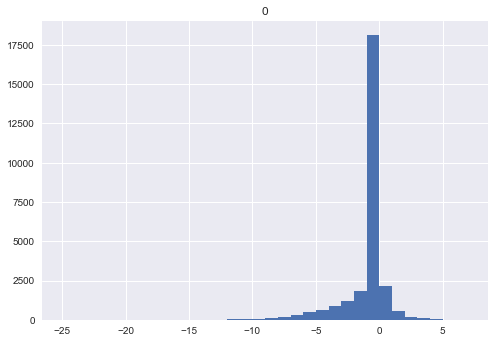

In [31]:
data = df_positions_pref_overall_deviations
data.hist(bins=range(data.min()[0], data.max()[0] + 1))
plt.show()

In [32]:
pref_is_not_best = 0

for index, row in df_skills_and_positions.iterrows():
    max_rating = int(row[player_positions].max())
    if all(int(row[pos]) < max_rating for pos in row['Preferred Positions'].split()):
        pref_is_not_best += 1

pref_is_not_best

3416

In [79]:
df_skills_and_positions.shape

(15952, 57)

In [149]:
df_skills_and_positions_binary = df_skills_and_positions.copy()

for pos in player_positions:
    df_skills_and_positions_binary[pos] = (df_skills_and_positions[pos] >= 0.95 * df_skills_and_positions[player_positions].max(axis=1)).astype(int)
    
df_skills_and_positions_binary.iloc[::2000, :]

,Crossing,Heading accuracy,Short passing,Volleys,Finishing,Free kick accuracy,Curve,Long passing,Dribbling,Ball control,...,LW,RW,CF,LF,RF,LS,RS,ST,Overall,Preferred Positions
0,85,88,83,88,94,76,81,77,91,93,...,1,1,1,1,1,1,1,1,94,ST LW
2225,71,72,68,35,28,34,52,61,74,73,...,0,0,0,0,0,0,0,0,74,LB
4411,59,46,76,61,50,55,70,72,76,78,...,1,1,1,1,1,0,0,0,71,CM
6615,48,63,61,71,66,41,48,60,65,68,...,1,1,1,1,1,1,1,1,69,ST
8828,56,47,63,12,30,22,48,59,33,53,...,0,0,0,0,0,0,0,0,66,RB CB
11040,34,70,54,57,65,31,34,35,64,68,...,0,0,1,1,1,1,1,1,64,ST
13305,57,44,66,37,53,59,54,61,61,60,...,1,1,1,1,1,0,0,0,62,CM
15593,33,56,50,40,61,33,41,28,58,52,...,0,0,1,1,1,1,1,1,58,ST


# Squad Problem

In [31]:
df.columns

Index(['Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential',
       'Club', 'Club Logo', 'Value', 'Wage', 'Special', 'Acceleration',
       'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure',
       'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy',
       'GK diving', 'GK handling', 'GK kicking', 'GK positioning',
       'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping',
       'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
       'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
       'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
       'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID', 'LAM', 'LB', 'LCB',
       'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'Preferred Positions',
       'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

In [32]:
df_squad = df.copy()
df_squad = df_squad[['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Preferred Positions'] + player_positions]
df_squad.head()

,Name,Age,Nationality,Overall,Potential,Club,Preferred Positions,CB,LCB,RCB,...,LAM,RAM,LW,RW,CF,LF,RF,LS,RS,ST
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,ST LW,53.0,53.0,53.0,...,89.0,89.0,91.0,91.0,91.0,91.0,91.0,92.0,92.0,92.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,RW,45.0,45.0,45.0,...,92.0,92.0,91.0,91.0,92.0,92.0,92.0,88.0,88.0,88.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,LW,46.0,46.0,46.0,...,88.0,88.0,89.0,89.0,88.0,88.0,88.0,84.0,84.0,84.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,ST,58.0,58.0,58.0,...,87.0,87.0,87.0,87.0,88.0,88.0,88.0,88.0,88.0,88.0
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,GK,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Replacing all NaNs with zeros

In [33]:
df_squad = df_squad.fillna(value=0.)
df_squad.head()

,Name,Age,Nationality,Overall,Potential,Club,Preferred Positions,CB,LCB,RCB,...,LAM,RAM,LW,RW,CF,LF,RF,LS,RS,ST
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,ST LW,53.0,53.0,53.0,...,89.0,89.0,91.0,91.0,91.0,91.0,91.0,92.0,92.0,92.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,RW,45.0,45.0,45.0,...,92.0,92.0,91.0,91.0,92.0,92.0,92.0,88.0,88.0,88.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,LW,46.0,46.0,46.0,...,88.0,88.0,89.0,89.0,88.0,88.0,88.0,84.0,84.0,84.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,ST,58.0,58.0,58.0,...,87.0,87.0,87.0,87.0,88.0,88.0,88.0,88.0,88.0,88.0
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,GK,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`GK` column is not present. We are adding it with values copied from `Overall` column.

In [34]:
df_squad['GK'] = df_squad['Preferred Positions'].str.contains('GK').astype(float) * df_squad['Overall']
df_squad.head()

,Name,Age,Nationality,Overall,Potential,Club,Preferred Positions,CB,LCB,RCB,...,RAM,LW,RW,CF,LF,RF,LS,RS,ST,GK
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,ST LW,53.0,53.0,53.0,...,89.0,91.0,91.0,91.0,91.0,91.0,92.0,92.0,92.0,0.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,RW,45.0,45.0,45.0,...,92.0,91.0,91.0,92.0,92.0,92.0,88.0,88.0,88.0,0.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,LW,46.0,46.0,46.0,...,88.0,89.0,89.0,88.0,88.0,88.0,84.0,84.0,84.0,0.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,ST,58.0,58.0,58.0,...,87.0,87.0,87.0,88.0,88.0,88.0,88.0,88.0,88.0,0.0
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,GK,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0


Now we are ready to write and test algorithms!

In [35]:
# list of formations
formation_352 = ['GK', 'CB', 'CB', 'CB', 'CDM', 'CDM', 'CAM', 'LM', 'RM', 'ST', 'ST']
formation_3412 = ['GK', 'CB', 'CB', 'CB', 'CM', 'CM', 'CAM', 'LM', 'RM', 'ST', 'ST']
formation_343 = ['GK', 'CB', 'CB', 'CB', 'CM', 'CM', 'LM', 'RM', 'LW', 'RW', 'ST']

formation_433 = ['GK', 'LB', 'CB', 'CB', 'RB', 'CM', 'CM', 'CM', 'LW', 'RW', 'ST']
formation_433_hold = ['GK', 'LB', 'CB', 'CB', 'RB', 'CDM', 'CM', 'CM', 'LW', 'RW', 'ST']
formation_442 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CM', 'CM', 'RM', 'ST', 'ST']
formation_451 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CM', 'RM', 'CAM', 'CAM', 'ST']

formation_532 = ['GK', 'LWB', 'CB', 'CB', 'CB', 'RWB', 'CM', 'CM', 'CM', 'ST', 'ST']

formation_list = [formation_352, formation_3412, formation_343,
                  formation_433, formation_433_hold, formation_442, formation_451,
                  formation_532]

Simple algorithm.

In [36]:
def find_best_squad_naive(players, positions):
    df_copy = players.copy()
    
    store = []
    
    for pos in positions:
        i = df_copy[pos].idxmax()

        player = df_copy.loc[[i]]
        store.append([pos , player['Name'].to_string(index = False), df_copy[pos].max()])
        
        df_copy.drop(i, inplace = True)

    squad = pd.DataFrame(np.array(store), columns = ['Position', 'Player', 'Rating'])
    return squad, float(squad[["Rating"]].astype(float).mean().round(2))

That was a naive and greedy approach, let's write a better algorithm.

In [42]:
def find_best_squad_opt(players, positions, verbose=False):
    df_copy = players.copy()
    
    store = []
    
    for pos in positions:
        i = df_copy[pos].idxmax()

        player = df_copy.loc[[i]]
        
        if verbose: print(pos)
        for j in range(len(store)):
            p = store[j][0]
            if p != pos:
                if verbose: print('Player\t' + player['Name'].to_string(index = False) + '\t' + player[pos].to_string(index = False))
                other_player = store[j][1]
                if verbose: print('Other\t' + other_player['Name'].to_string(index = False) + '\t' + other_player[pos].to_string(index = False))
                if float(other_player[pos]) > float(player[pos]):
                    if verbose: print('\tPossible change?')
                    if verbose: print(f'Player\t{player["Name"].to_string(index = False)}\t{p}({float(player[p])})')
                    if verbose: print(f'Other\t{other_player["Name"].to_string(index = False)}\t{p}({float(other_player[p])})')
                    
                # substitution is better
                if float(other_player[pos]) + float(player[p]) > float(other_player[p]) + float(player[pos]):
                    if verbose: print('\tChanging players')
                    if verbose: print(f'Player\t{player["Name"].to_string(index = False)}\t{pos}({float(player[pos])}) -> {p}({float(player[p])})')
                    if verbose: print(f'Other\t{other_player["Name"].to_string(index = False)}\t{p}({float(other_player[p])}) -> {pos}({float(other_player[pos])})')
                    store[j] = [p , player]
                    player = other_player
                if verbose: print('=' * 10)
        
        store.append([pos , player])
        
        
        store_res = []
        for row in store:
            pos = row[0]
            player = row[1]
            store_res.append([pos , player['Name'].to_string(index = False), float(player[pos])])    
        if verbose: print('*' * 20)
        if verbose: print(pd.DataFrame(np.array(store_res), columns = ['Position', 'Player', 'Rating']))
        if verbose: print('*' * 20)
        
        df_copy.drop(i, inplace = True)
    
    store_res = []
    for row in store:
        pos = row[0]
        player = row[1]
        store_res.append([pos , player['Name'].to_string(index = False), float(player[pos])])

    squad = pd.DataFrame(np.array(store_res), columns = ['Position', 'Player', 'Rating'])
    return squad, float(squad[["Rating"]].astype(float).mean().round(2))

In [43]:
def find_best_squad_opt_complete(players, positions, verbose=False):
    df_copy = players.copy()
    df_copy_init = df_copy.copy()
    
    store = []
    
    pos_to_recheck = set()
    
    for pos in positions:
        players = []
        
        # selecting best players at position `pos`
        players = df_copy[df_copy[pos] == df_copy[pos].max()]
        
        if verbose: print('#' * 10 + ' ' + pos)
        for j in range(len(store)):
            pos_other = store[j][0]
            if pos_other != pos:
                players_other = store[j][1]
                
                # checking if any at `other_pos` can play better at `pos`
                better_at_pos = players_other[players_other[pos] == players_other[pos].max()]
                if verbose: print(players[['Name', pos, pos_other]])
                if verbose: print(better_at_pos[['Name', pos, pos_other]])
                    
                rating_players_pos = players[pos].max()
                rating_players_pos_other = players[pos_other].max()
                rating_players_other_pos = players_other[pos].max()
                rating_players_other_pos_other = players_other[pos_other].max()
                
                if rating_players_other_pos > rating_players_pos:
                    if better_at_pos.shape[0] > 1:
                        # several from `pos_other` are better at `pos`
                        if players_other.shape[0] - better_at_pos.shape[0] >= 1:
                            # move all best at `pos_other` to `pos` if rating is higher
                            if verbose: print(f'Moving {better_at_pos.shape[0]} players')
                            players = better_at_pos.copy()
                            
                            df_temp = players_other.copy()
                            df_temp.drop(better_at_pos.index, inplace = True)
                            players_other = df_temp
                            
                            store[j] = [pos_other, players_other]
                        else:
                            # move any but leaving one at `other_pos` if rating is higher. let's move first one 
                            if verbose: print('Moving 1 player')
                            players = better_at_pos.loc[better_at_pos.index[0]:better_at_pos.index[0], :].copy()
                            
                            df_temp = players_other.copy()
                            df_temp.drop(better_at_pos.index[0], inplace = True)
                            players_other = df_temp
                            store[j] = [pos_other, players_other]
                        
                            if verbose: print(players[['Name', pos, pos_other]])
                            if verbose: print(players_other[['Name', pos, pos_other]])
                    else:
                        # only one can be moved if rating is higher
                        if players_other.shape[0] > 1:
                            # move one best at `pos_other` to `pos`
                            if verbose: print('Moving 1 player')
                            players = better_at_pos.copy()
                            
                            df_temp = players_other.copy()
                            df_temp.drop(better_at_pos.index, inplace = True)
                            players_other = df_temp
                            
                            store[j] = [pos_other, players_other]
                            
                            if verbose: print(players[['Name', pos, pos_other]])
                            if verbose: print(players_other[['Name', pos, pos_other]])
                        else:
                            # move can be done only in the case of substitution
                            if rating_players_other_pos + rating_players_pos_other > rating_players_other_pos_other + rating_players_pos:
                                # moving all best at `pos_other` from `pos` to `other_pos`
                                if verbose: print('Substituting players')
                                
                                players_other = players[players[pos_other] == players[pos_other].max()].copy()
                                store[j] = [pos_other, players_other]
                                players = better_at_pos
                                
                                pos_to_recheck.add(pos_other)
            
                                if verbose: print(players[['Name', pos, pos_other]])
                                if verbose: print(players_other[['Name', pos, pos_other]])
                if verbose: print('=' * 10)
        
        store.append([pos , players])
        
        df_copy = df_copy_init.copy()
        for p in store:
            try:
                df_copy.drop(p[1].index, inplace = True)
            except ValueError:
                pass
    
    # another loop for better convergence
    while len(pos_to_recheck) > 0:
        for i in range(len(store)):
            players = store[i][1]
            pos = store[i][0]
            
            if pos not in pos_to_recheck:
                continue  
            
            pos_to_recheck.remove(pos)

            if verbose: print('#' * 10 + ' ' + pos)
            for j in range(len(store)):
                pos_other = store[j][0]
                if pos_other != pos:
                    players_other = store[j][1]

                    # checking if any at `other_pos` can play better at `pos`
                    better_at_pos = players_other[players_other[pos] == players_other[pos].max()]
                    if verbose: print(players[['Name', pos, pos_other]])
                    if verbose: print(better_at_pos[['Name', pos, pos_other]])

                    rating_players_pos = players[pos].max()
                    rating_players_pos_other = players[pos_other].max()
                    rating_players_other_pos = players_other[pos].max()
                    rating_players_other_pos_other = players_other[pos_other].max()

                    if rating_players_other_pos > rating_players_pos:
                        if better_at_pos.shape[0] > 1:
                            # several from `pos_other` are better at `pos`
                            if players_other.shape[0] - better_at_pos.shape[0] >= 1:
                                # move all best at `pos_other` to `pos` if rating is higher
                                if verbose: print(f'Moving {better_at_pos.shape[0]} players')
                                players = better_at_pos.copy()

                                df_temp = players_other.copy()
                                df_temp.drop(better_at_pos.index, inplace = True)
                                players_other = df_temp

                                store[i] = [pos, players]
                                store[j] = [pos_other, players_other]
                            else:
                                # move any but leaving one at `other_pos` if rating is higher. let's move first one 
                                if verbose: print('Moving 1 player')
                                players = better_at_pos.loc[better_at_pos.index[0]:better_at_pos.index[0], :].copy()

                                df_temp = players_other.copy()
                                df_temp.drop(better_at_pos.index[0], inplace = True)
                                players_other = df_temp

                                store[i] = [pos, players]
                                store[j] = [pos_other, players_other]

                                if verbose: print(players[['Name', pos, pos_other]])
                                if verbose: print(players_other[['Name', pos, pos_other]])
                        else:
                            # only one can be moved if rating is higher
                            if players_other.shape[0] > 1:
                                # move one best at `pos_other` to `pos`
                                if verbose: print('Moving 1 player')
                                players = better_at_pos.copy()

                                df_temp = players_other.copy()
                                df_temp.drop(better_at_pos.index, inplace = True)
                                players_other = df_temp

                                store[i] = [pos, players]
                                store[j] = [pos_other, players_other]

                                if verbose: print(players[['Name', pos, pos_other]])
                                if verbose: print(players_other[['Name', pos, pos_other]])
                            else:
                                # move can be done only in the case of substitution
                                if rating_players_other_pos + rating_players_pos_other > rating_players_other_pos_other + rating_players_pos:
                                    # moving all best at `pos_other` from `pos` to `other_pos`
                                    if verbose: print('Substituting players')

                                    players_other = players[players[pos_other] == players[pos_other].max()].copy()
                                    store[j] = [pos_other, players_other]
                                    players = better_at_pos
                                    store[i] = [pos, players]
                                    
                                    pos_to_recheck.add(pos_other)

                                    if verbose: print(players[['Name', pos, pos_other]])
                                    if verbose: print(players_other[['Name', pos, pos_other]])
                    if verbose: print('=' * 10)
     
    store_res = []
    for row in store:
        pos = row[0]
        players = row[1]
        player = players.loc[players.index[0]:players.index[0], :].copy()
        store_res.append([pos , player['Name'].to_string(index = False), float(player[pos])])

    squad = pd.DataFrame(np.array(store_res), columns = ['Position', 'Player', 'Rating'])
    return squad, float(squad[["Rating"]].astype(float).mean().round(2))

In [47]:
def get_formations_info(players, formation_list, optimal_squad_func=find_best_squad_opt_complete):
    formations = []
    for formation in formation_list:
        squad, avg_rating = optimal_squad_func(players, formation)
        formations.append((formation, squad, avg_rating))
    return formations

In [48]:
def find_best_formation(players, formation_list, optimal_squad_func=find_best_squad_opt_complete):
    best_formations = [(None, None, 0.)]
    for formation in formation_list:
        squad, avg_rating = optimal_squad_func(players, formation)
        if avg_rating > best_formations[0][2]:
            best_formations = [(formation, squad, avg_rating)]
        elif avg_rating == best_formations[0][2]:
            best_formations.append((formation, squad, avg_rating))
    return best_formations

### Testing algorithms

In [39]:
df_liverpool = df_squad[df_squad['Club']  == 'Liverpool']
df_liverpool.head()

,Name,Age,Nationality,Overall,Potential,Club,Preferred Positions,CB,LCB,RCB,...,RAM,LW,RW,CF,LF,RF,LS,RS,ST,GK
54,Coutinho,25,Brazil,86,89,Liverpool,CAM LW,49.0,49.0,49.0,...,85.0,84.0,84.0,83.0,83.0,83.0,77.0,77.0,77.0,0.0
97,S. Mané,25,Senegal,84,87,Liverpool,LW RW,51.0,51.0,51.0,...,81.0,83.0,83.0,82.0,82.0,82.0,79.0,79.0,79.0,0.0
137,M. Salah,25,Egypt,83,86,Liverpool,RW,56.0,56.0,56.0,...,81.0,83.0,83.0,82.0,82.0,82.0,78.0,78.0,78.0,0.0
145,Roberto Firmino,25,Brazil,83,87,Liverpool,CAM CF ST,58.0,58.0,58.0,...,83.0,82.0,82.0,83.0,83.0,83.0,81.0,81.0,81.0,0.0
151,J. Matip,25,Cameroon,83,85,Liverpool,CB,82.0,82.0,82.0,...,66.0,63.0,63.0,64.0,64.0,64.0,63.0,63.0,63.0,0.0


In [40]:
squad, avg_rating = find_best_squad_naive(df_liverpool, formation_433)
print(f'{squad}\n\nAverage rating: {avg_rating}')

   Position           Player Rating
0        GK      S. Mignolet   81.0
1        LB         N. Clyne   81.0
2        CB         J. Matip   82.0
3        CB        D. Lovren   80.0
4        RB     J. Henderson   79.0
5        CM       A. Lallana   81.0
6        CM     G. Wijnaldum   80.0
7        CM        J. Milner   80.0
8        LW         Coutinho   84.0
9        RW          S. Mané   83.0
10       ST  Roberto Firmino   81.0

Average rating: 81.09


In [44]:
squad, avg_rating = find_best_squad_opt(df_liverpool, formation_433)
print(f'{squad}\n\nAverage rating: {avg_rating}')

   Position           Player Rating
0        GK      S. Mignolet   81.0
1        LB         N. Clyne   81.0
2        CB         J. Matip   82.0
3        CB        D. Lovren   80.0
4        RB        J. Milner   79.0
5        CM       A. Lallana   81.0
6        CM     G. Wijnaldum   80.0
7        CM     J. Henderson   81.0
8        LW         Coutinho   84.0
9        RW          S. Mané   83.0
10       ST  Roberto Firmino   81.0

Average rating: 81.18


In [45]:
squad, avg_rating = find_best_squad_opt_complete(df_liverpool, formation_433)
print(f'{squad}\n\nAverage rating: {avg_rating}')

   Position           Player Rating
0        GK      S. Mignolet   81.0
1        LB         N. Clyne   81.0
2        CB         J. Matip   82.0
3        CB        D. Lovren   80.0
4        RB        J. Milner   79.0
5        CM       A. Lallana   81.0
6        CM     J. Henderson   81.0
7        CM     G. Wijnaldum   80.0
8        LW         Coutinho   84.0
9        RW          S. Mané   83.0
10       ST  Roberto Firmino   81.0

Average rating: 81.18


In [49]:
find_best_formation(df_liverpool, formation_list, optimal_squad_func=find_best_squad_naive)

[(['GK', 'CB', 'CB', 'CB', 'CM', 'CM', 'CAM', 'LM', 'RM', 'ST', 'ST'],
     Position           Player Rating
  0        GK      S. Mignolet   81.0
  1        CB         J. Matip   82.0
  2        CB        D. Lovren   80.0
  3        CB           E. Can   79.0
  4        CM       A. Lallana   81.0
  5        CM     J. Henderson   81.0
  6       CAM         Coutinho   85.0
  7        LM          S. Mané   82.0
  8        RM         M. Salah   82.0
  9        ST  Roberto Firmino   81.0
  10       ST     D. Sturridge   80.0,
  81.27),
 (['GK', 'CB', 'CB', 'CB', 'CM', 'CM', 'LM', 'RM', 'LW', 'RW', 'ST'],
     Position           Player Rating
  0        GK      S. Mignolet   81.0
  1        CB         J. Matip   82.0
  2        CB        D. Lovren   80.0
  3        CB           E. Can   79.0
  4        CM       A. Lallana   81.0
  5        CM     J. Henderson   81.0
  6        LM         Coutinho   83.0
  7        RM          S. Mané   82.0
  8        LW         M. Salah   83.0
  9        R

In [50]:
find_best_formation(df_liverpool, formation_list, optimal_squad_func=find_best_squad_opt)

[(['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CM', 'RM', 'CAM', 'CAM', 'ST'],
     Position           Player Rating
  0        GK      S. Mignolet   81.0
  1        LB         N. Clyne   81.0
  2        CB         J. Matip   82.0
  3        CB        D. Lovren   80.0
  4        RB     J. Henderson   79.0
  5        LM         M. Salah   82.0
  6        CM       A. Lallana   81.0
  7        RM          S. Mané   82.0
  8       CAM         Coutinho   85.0
  9       CAM  Roberto Firmino   83.0
  10       ST     D. Sturridge   80.0,
  81.45)]

In [51]:
find_best_formation(df_liverpool, formation_list, optimal_squad_func=find_best_squad_opt_complete)

[(['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CM', 'RM', 'CAM', 'CAM', 'ST'],
     Position           Player Rating
  0        GK      S. Mignolet   81.0
  1        LB         N. Clyne   81.0
  2        CB         J. Matip   82.0
  3        CB        D. Lovren   80.0
  4        RB     J. Henderson   79.0
  5        LM          S. Mané   82.0
  6        CM       A. Lallana   81.0
  7        RM         M. Salah   82.0
  8       CAM         Coutinho   85.0
  9       CAM  Roberto Firmino   83.0
  10       ST     D. Sturridge   80.0,
  81.45)]

In [52]:
df_russian = df_squad[df_squad['Nationality'] == 'Russia']
df_russian.head()

,Name,Age,Nationality,Overall,Potential,Club,Preferred Positions,CB,LCB,RCB,...,RAM,LW,RW,CF,LF,RF,LS,RS,ST,GK
342,Mário Fernandes,26,Russia,81,82,CSKA Moscow,RM RWB,79.0,79.0,79.0,...,74.0,75.0,75.0,74.0,74.0,74.0,72.0,72.0,72.0,0.0
413,O. Shatov,26,Russia,80,80,Zenit St. Petersburg,RW LW LM,57.0,57.0,57.0,...,79.0,79.0,79.0,79.0,79.0,79.0,75.0,75.0,75.0,0.0
455,A. Dzagoev,27,Russia,80,81,CSKA Moscow,CF CDM CM,71.0,71.0,71.0,...,78.0,78.0,78.0,78.0,78.0,78.0,76.0,76.0,76.0,0.0
457,F. Smolov,27,Russia,80,81,FC Krasnodar,ST,49.0,49.0,49.0,...,77.0,77.0,77.0,79.0,79.0,79.0,79.0,79.0,79.0,0.0
536,S. Kritsyuk,26,Russia,79,82,FC Krasnodar,GK,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0


In [53]:
print(find_best_squad_naive(df_russian, formation_433))
print(find_best_squad_opt(df_russian, formation_433))
print(find_best_squad_opt_complete(df_russian, formation_433))

(   Position           Player Rating
0        GK      S. Kritsyuk   79.0
1        LB  Mário Fernandes   80.0
2        CB   V. Berezutskiy   78.0
3        CB   S. Ignashevich   77.0
4        RB     I. Smolnikov   78.0
5        CM       A. Dzagoev   78.0
6        CM     D. Glushakov   77.0
7        CM        R. Zobnin   76.0
8        LW        O. Shatov   79.0
9        RW       A. Kokorin   78.0
10       ST        F. Smolov   79.0, 78.09)
(   Position           Player Rating
0        GK      S. Kritsyuk   79.0
1        LB  Mário Fernandes   80.0
2        CB   V. Berezutskiy   78.0
3        CB   S. Ignashevich   77.0
4        RB     I. Smolnikov   78.0
5        CM       A. Dzagoev   78.0
6        CM     D. Glushakov   77.0
7        CM        R. Zobnin   76.0
8        LW        O. Shatov   79.0
9        RW       A. Kokorin   78.0
10       ST        F. Smolov   79.0, 78.09)
(   Position           Player Rating
0        GK      S. Kritsyuk   79.0
1        LB  Mário Fernandes   80.0
2        

### Evaluation on all teams

In [60]:
def evaluate_methods(df, measure, teams, formations, methods):
    stats = np.zeros(len(methods) + 1)
    squad = None
    count = 0
    
    c = 0
    for team in teams:
        c += 1
        df_temp = df[df[measure] == team].copy()
        if df_temp.shape[0] > 30:
            for formation in formations:
                count += 1
                avg_ratings = np.zeros(len(methods))
                for i in range(len(methods)):
                    squad, avg_ratings[i] = methods[i](df_temp, formation)
                comb = 0
                for j in np.where(avg_ratings == avg_ratings.max())[0]:
                    stats[j] += 1
                    if j == 1: 
                        comb = 1
                    if j == 2: 
                        comb = 1    
                stats[3] += comb
                                      
    return stats, count

In [56]:
nationalities = df_squad['Nationality'].unique()
nationalities

array(['Portugal', 'Argentina', 'Brazil', 'Uruguay', 'Germany', 'Poland',
       'Spain', 'Belgium', 'Chile', 'Croatia', 'Wales', 'Italy',
       'Slovenia', 'France', 'Gabon', 'Sweden', 'Netherlands', 'Denmark',
       'Slovakia', 'England', 'Colombia', 'Austria', 'Greece',
       'Czech Republic', 'Costa Rica', 'Armenia', 'Bosnia Herzegovina',
       'Ivory Coast', 'Senegal', 'Switzerland', 'Morocco', 'Guinea',
       'Egypt', 'Algeria', 'Cameroon', 'Serbia', 'Japan', 'Turkey',
       'Ecuador', 'Montenegro', 'Korea Republic', 'Kenya', 'Iceland',
       'Mexico', 'Norway', 'DR Congo', 'Ukraine', 'Russia', 'Finland',
       'Republic of Ireland', 'United States', 'Venezuela', 'Ghana',
       'Uzbekistan', 'Nigeria', 'Canada', 'Paraguay', 'Romania', 'Albania',
       'Burkina Faso', 'Cape Verde', 'New Zealand', 'Northern Ireland',
       'Syria', 'Peru', 'Scotland', 'Bulgaria', 'Angola', 'Australia',
       'South Africa', 'Jamaica', 'Tunisia', 'Mozambique', 'Iran', 'Mali',
       'Cub

In [61]:
stats_nat = evaluate_methods(df_squad, 
                 'Nationality', 
                 nationalities, 
                 formation_list, 
                 [find_best_squad_naive, find_best_squad_opt, find_best_squad_opt_complete])
stats_nat

(array([ 148.,  338.,  369.,  520.]), 520)

In [63]:
clubs = df_squad['Club'].unique()
clubs

array(['Real Madrid CF', 'FC Barcelona', 'Paris Saint-Germain',
       'FC Bayern Munich', 'Manchester United', 'Chelsea', 'Juventus',
       'Manchester City', 'Arsenal', 'Atlético Madrid',
       'Borussia Dortmund', 'Milan', 'Tottenham Hotspur', 'Napoli',
       'Inter', 'Liverpool', 'Roma', 'Beşiktaş JK', 'AS Monaco',
       'Bayer 04 Leverkusen', 'AS Saint-Étienne',
       'Athletic Club de Bilbao', '1. FC Köln', 'Villarreal CF',
       'FC Schalke 04', 'Olympique de Marseille', 'Atalanta', 'RB Leipzig',
       'Real Sociedad', 'Torino', 'Sporting CP', 'Leicester City',
       'Southampton', 'FC Porto', 'UD Las Palmas', 'Olympique Lyonnais',
       'Lazio', 'Genoa', 'Everton', 'RC Celta de Vigo', 'Valencia CF', 0.0,
       'Sevilla FC', 'Toronto FC', 'Borussia Mönchengladbach',
       'SL Benfica', 'RCD Espanyol', 'OGC Nice', 'Spartak Moscow',
       'Swansea City', 'Sassuolo', 'TSG 1899 Hoffenheim', 'Stoke City',
       'Shakhtar Donetsk', 'West Ham United', 'SV Werder Bremen',
 

In [65]:
stats_club = evaluate_methods(df_squad, 
                 'Club', 
                 clubs, 
                 formation_list, 
                 [find_best_squad_naive, find_best_squad_opt, find_best_squad_opt_complete])
stats_club

(array([ 1166.,  3254.,  3510.,  4920.]), 4920)

In [66]:
df_stats = pd.DataFrame({'national (65 teams)': stats_nat[0] / stats_nat[1], 'club (615 teams)': stats_club[0] / stats_club[1]})
df_stats

,club (615 teams),national (65 teams)
0,0.236992,0.284615
1,0.661382,0.650000
2,0.713415,0.709615
3,1.000000,1.000000


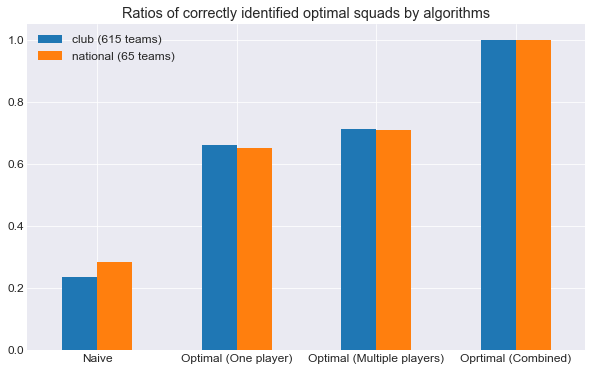

In [67]:
x = np.arange(4)

fig, ax = plt.subplots()
df_stats.plot.bar(title='Ratios of correctly identified optimal squads by algorithms', ax=ax, figsize=(10,6))
ax.set_xticklabels(['Naive', 'Optimal (One player)', 'Optimal (Multiple players)', 'Oprtimal (Combined)'], rotation=0)
plt.show()